# Introducing a momentum indicator to the mean reversion strategy
We have already built a strategy that uses Bollinger bands to identify exit and entry points based on mean reversion. However, we can add a momentum indicator to confirm the strength and validity of the mean reversion strategy.

We can use a RSI or ADX indicator. A Relative Srrength Index (RSI) measures thestrength of the trend of the stock and is often used to indicate when a stock is overbought or oversold. These can be good signs that the price will increase or drop. Similarly the Trend Strenght Indicator (ADX) measures the magnitude of the trend but not the direction. We can quantify how fast the price is increasing and using this to accept or deny entry/exit. 

We will import the fundamentals of the mean reversion stratregy and still use only Apple and META as our two stocks. 

In [16]:
import bt
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as pltb

We download and sort out the stock data for Apple and META , keeping only the adjusted close prices.

In [17]:
m = None
# Load Apple and Meta priecs
aapl_data = yf.download(tickers = 'AAPL', start = '2017-01-01', end ='2024-09-30', interval = '1d')
meta_data = yf.download(tickers = 'META', start = '2017-01-01', end ='2024-09-30', interval = '1d')
backtest_data = aapl_data.copy()
backtest_data['Open'] = aapl_data['Adj Close']
backtest_data['High'] = meta_data['Adj Close']
backtest_data = backtest_data.drop(['Low','Close','Adj Close','Volume'], axis = 1)
backtest_data = backtest_data.rename(columns = {'Open' : 'AAPL', 'High' : 'META'})
backtest_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,META
Date,,
2017-01-03,26.921549,116.509209
2017-01-04,26.891417,118.333710
2017-01-05,27.028168,120.307770
2017-01-06,27.329483,123.039551
2017-01-09,27.579809,124.525070
...,...,...
2024-09-23,226.470001,564.409973
2024-09-24,227.369995,563.330017
2024-09-25,226.369995,568.309998


## AAPL META Mean Reversion

this is taken from the mean reversion notebook.

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


<Axes: title={'center': 'Equity Progression'}>

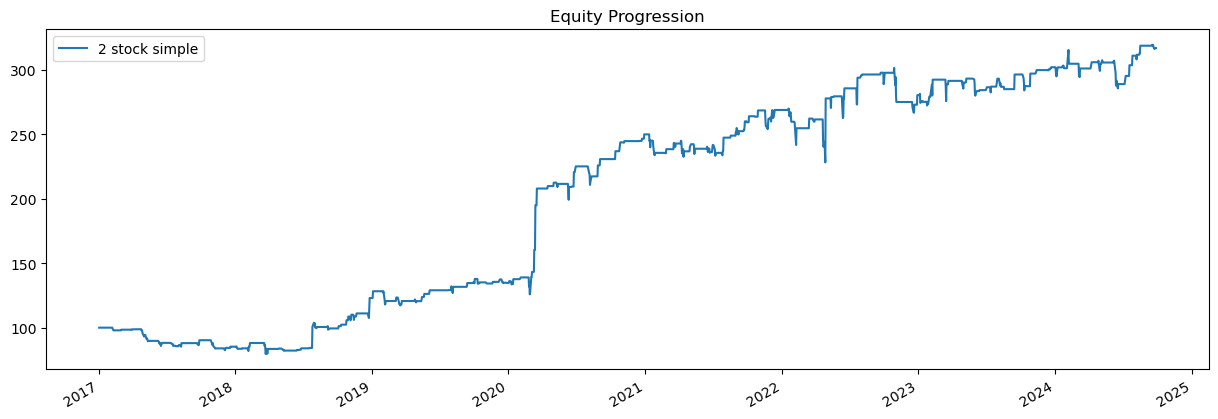

In [18]:
# Set the Moveing Averge window
window = 24

# Calculate the SMA with this Widnow
sma = backtest_data.rolling(window).mean()

# Calculate the Upper and Lower Bollinger bands
upper_boll_1 = sma + 2*backtest_data.rolling(window=window).std()
lower_boll_1 = sma - 2*backtest_data.rolling(window=window).std()
upper_boll_2 = sma + 1*backtest_data.rolling(window=window).std()
lower_boll_2 = sma - 1*backtest_data.rolling(window=window).std()


# Copy the structure of the stock data, mainly the date column
signal = backtest_data.copy()

# Set values in df to NaN
signal[:] = np.nan

# Buy signal when the price drops below the 2std lower bollinger line 
buy_condition = ((backtest_data < lower_boll_1))
signal[buy_condition] = True  # Buy signal (True)



# Sell signal when the price is above the 2std upper Bollinger line
sell_condition = ((backtest_data > upper_boll_1))
signal[sell_condition] = False

# Create the Weight allocation class 
class WeighTarget(bt.Algo):
    
    def __init__(self, target_weights, signal):
        self.tw = target_weights
        self.signal = signal
    
    def __call__(self, target):
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            w = w.where(self.signal.loc[target.now].notna(), other=0)
            
            target.temp['weights'] = w.dropna()
    
        return True


# Produce the target weight df 
tw = backtest_data.copy()

# Set inital weights to 0
tw[:] = 0.0

# Outline the conditions of the outside bands by negating the condition that is inside
outside_bands = ~((backtest_data < upper_boll_2) & (backtest_data > lower_boll_2))

# Set-up a df that will keep track if we are entered into a position or not
in_pos = tw.copy()
in_pos[:] = np.nan

# Sets to True when the buy(long) or sell(short) condition is true
in_pos[buy_condition | sell_condition] = True

# We forward fill the df to 'hold' the position 
in_pos.ffill(inplace = True)

# We exit out of positionby setting to false when not outside (inside) the stable zone
in_pos[~((outside_bands))] = False

# Set weight to 1.0 (long position) when the price is below the Lower bollinger line
tw[((backtest_data < lower_boll_1))] = 1.0

# Set weight to -1.0 (short) when price is above the Upper bollinger line
tw[((backtest_data > upper_boll_1))] = -1.0

# Now we need to iterate through rows to propagate holding positions
for i in range(1, len(tw)):
    # Loops through each ticker ('AAPL', 'META')
    for col in tw.columns:
        # Use .loc to access rows/columns using label-based indexing
        if tw.loc[tw.index[i-1], col] == 1.0 and outside_bands.loc[tw.index[i], col] and in_pos.loc[tw.index[i], col]:
            # If the previous row had a long position and the price is still outside bands and we're in position
            tw.loc[tw.index[i], col] = 1.0  # Hold long position
        elif tw.loc[tw.index[i-1], col] == -1.0 and outside_bands.loc[tw.index[i], col] and in_pos.loc[tw.index[i], col]:
            # If the previous row had a short position and the price is still outside bands and we're in position
            tw.loc[tw.index[i], col] = -1.0  # Hold short position
        
            

# Produce the Strategy
s = bt.Strategy('2 stock simple', [bt.algos.RunDaily(),             # Run Daily
                          bt.algos.SelectAll(),            # Select all stocks
                          WeighTarget(tw,signal),          # Weight allocation
                          bt.algos.Rebalance()])           # Rebalance


# now we create the Backtest
t = bt.Backtest(s, backtest_data, initial_capital = 1000)

# Run the Backtest
res = bt.run(t)

# Plot the Backtest
res.plot()

In [19]:
# Display stats of Backtest
res.display()
stats = res.stats 

# Add stats to a df
m = pd.concat([m, stats], axis=0)

Stat                 2 stock simple
-------------------  ----------------
Start                2017-01-02
End                  2024-09-27
Risk-free rate       0.00%

Total Return         216.96%
Daily Sharpe         0.82
Daily Sortino        1.77
CAGR                 16.08%
Max Drawdown         -20.41%
Calmar Ratio         0.79

MTD                  -0.59%
3m                   9.66%
6m                   5.24%
YTD                  4.91%
1Y                   6.90%
3Y (ann.)            6.81%
5Y (ann.)            18.67%
10Y (ann.)           -
Since Incep. (ann.)  16.08%

Daily Sharpe         0.82
Daily Sortino        1.77
Daily Mean (ann.)    16.97%
Daily Vol (ann.)     20.77%
Daily Skew           7.58
Daily Kurt           115.43
Best Day             21.75%
Worst Day            -6.24%

Monthly Sharpe       0.68
Monthly Sortino      3.05
Monthly Mean (ann.)  17.81%
Monthly Vol (ann.)   26.35%
Monthly Skew         6.20
Monthly Kurt         48.73
Best Month           63.25%
Worst Month       

We see that the mean reversion alone has total returns of 216%, A yearly Sharpe Ratio of 0.76, avergage draw down of -4.93%. Our worst year was +4.29%. This is a good return but the Sharpe ratio isnt high.

## AAPL META Mean Reversion + RSI indicator

We now introduce the RSI and use it to qualify our entry positions.

We calculate the RSI, using the code from the technical indicators notebook.

In [20]:
# To calculate the RSI we need t calculate the difference in prices between successive intervals
change = backtest_data.diff()
change.dropna(inplace=True)
change_up = change.copy()
change_down = change.copy()

# Keep only the positive differences in the change up list
change_up[change_up<0] = 0

# Keep only the negative difference in the change down list
change_down[change_down>0] = 0

# Take the average upwawrds movement and average downwards movement over a a 14 day window
avg_up = change_up.rolling(14).mean()
avg_down = change_down.rolling(14).mean().abs()

# RSI is calculated by the propertion of upards movements from total movement(up + down). We take as value between 0 and 100
RSI = 100 * avg_up / (avg_up + avg_down)

RSI

,AAPL,META
Date,,
2017-01-04,NaN,NaN
2017-01-05,NaN,NaN
2017-01-06,NaN,NaN
2017-01-09,NaN,NaN
2017-01-10,NaN,NaN
...,...,...
2024-09-23,56.174900,80.108328
2024-09-24,61.264678,78.908623
2024-09-25,57.022165,79.112870


We then use the same weight code and strategy construction except the addition of the RSI into the long and short entry conditions.

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


<Axes: title={'center': 'Equity Progression'}>

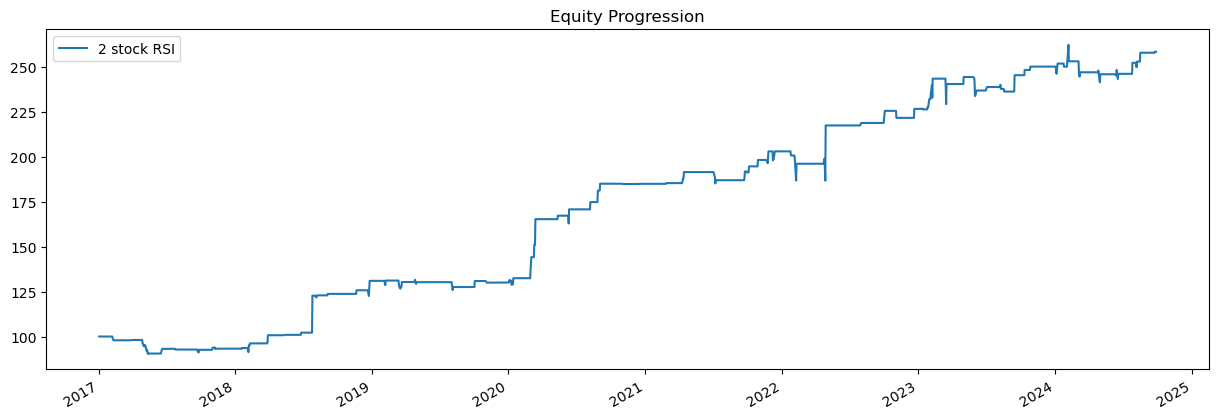

In [21]:
# Set the Moveing Averge window
window = 24

# Calculate the SMA with this Widnow
sma = backtest_data.rolling(window).mean()

# Calculate the Upper and Lower Bollinger bands
upper_boll_1 = sma + 2*backtest_data.rolling(window=window).std()
lower_boll_1 = sma - 2*backtest_data.rolling(window=window).std()
upper_boll_2 = sma + 1*backtest_data.rolling(window=window).std()
lower_boll_2 = sma - 1*backtest_data.rolling(window=window).std()


# Copy the structure of the stock data, mainly the date column
signal = backtest_data.copy()

# Set values in df to NaN
signal[:] = np.nan

# Buy signal when the price drops below the 2std lower bollinger line and the RSI < 25 (oversold)
buy_condition = ((backtest_data < lower_boll_1) & (RSI < 25))
signal[buy_condition] = True  # Buy signal (True)



# Sell signal when the price is above the 2std upper Bollinger line and the RSI > 75 (verbought)
sell_condition = ((backtest_data > upper_boll_1) & (RSI > 75))
signal[sell_condition] = False

# Create the Weight allocation class 
class WeighTarget(bt.Algo):
    
    def __init__(self, target_weights, signal):
        self.tw = target_weights
        self.signal = signal
    
    def __call__(self, target):
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            w = w.where(self.signal.loc[target.now].notna(), other=0)
            
            target.temp['weights'] = w.dropna()
    
        return True


# Produce the target weight df 
tw = backtest_data.copy()

# Set inital weights to 0
tw[:] = 0.0

# Outline the conditions of the outside bands by negating the condition that is inside
outside_bands = ~((backtest_data < upper_boll_2) & (backtest_data > lower_boll_2))

# Set-up a df that will keep track if we are entered into a position or not
in_pos = tw.copy()
in_pos[:] = np.nan

# Sets to True when the buy(long) or sell(short) condition is true
in_pos[buy_condition | sell_condition] = True

# We forward fill the df to 'hold' the position 
in_pos.ffill(inplace = True)

# We exit out of positionby setting to false when not outside (inside) the stable zone
in_pos[(~((outside_bands))) ] = False

# Set weight to 1.0 (long position) when the price is below the Lower bollinger line
tw[((backtest_data < lower_boll_1))] = 1.0

# Set weight to -1.0 (short) when price is above the Upper bollinger line
tw[((backtest_data > upper_boll_1))] = -1.0

# Now we need to iterate through rows to propagate holding positions
for i in range(1, len(tw)):
    # Loops through each ticker ('AAPL', 'META')
    for col in tw.columns:
        # Use .loc to access rows/columns using label-based indexing
        if tw.loc[tw.index[i-1], col] == 1.0 and outside_bands.loc[tw.index[i], col] and in_pos.loc[tw.index[i], col]:
            # If the previous row had a long position and the price is still outside bands and we're in position
            tw.loc[tw.index[i], col] = 1.0  # Hold long position
        elif tw.loc[tw.index[i-1], col] == -1.0 and outside_bands.loc[tw.index[i], col] and in_pos.loc[tw.index[i], col]:
            # If the previous row had a short position and the price is still outside bands and we're in position
            tw.loc[tw.index[i], col] = -1.0  # Hold short position
        

# Produce the Strategy
s = bt.Strategy('2 stock RSI', [bt.algos.RunDaily(),             # Run Daily
                          bt.algos.SelectAll(),            # Select all stocks
                          WeighTarget(tw,signal),          # Weight allocation
                          bt.algos.Rebalance()])           # Rebalance


# now we create the Backtest
t = bt.Backtest(s, backtest_data, initial_capital = 1000)

# Run the Backtest
res = bt.run(t)

# Plot the Backtest
res.plot()
res.display()
stats = res.stats 
m = pd.concat([m, stats], axis=1)



We see that we got less total return at 158%, but our Sharpe Ratio increased to 0.96 and our avergae draw down was less at -2.98%. Our worst year was -0.720%. This suggests that the RSI limits our total return by not entering good positions, but it also stopped a number of false entries that would have resulted in a loss.

I am interested in increasing the number of securites we use. Lets introduce 3 more for a total of 5, we will have Nvidia, Tesla and Google. 

## 5 stock mean reversion

We download all the data from the 5 stocks we are interested in. We save the OHLC data to be used for the ADX later. We keep the adjusted price to use for the backtest.

In [23]:
data = []

aapl_data = yf.download(tickers = 'AAPL', start = '2017-01-01', end ='2024-09-30', interval = '1d')
meta_data = yf.download(tickers = 'META', start = '2017-01-01', end ='2024-09-30', interval = '1d')
tsla_data = yf.download(tickers = 'AMZN', start = '2017-01-01', end ='2024-09-30', interval = '1d')
nvda_data = yf.download(tickers = 'NVDA', start = '2017-01-01', end ='2024-09-30', interval = '1d')
goog_data = yf.download(tickers = 'GOOG', start = '2017-01-01', end ='2024-09-30', interval = '1d')

# ADX data
data.append([aapl_data,meta_data,tsla_data,nvda_data,goog_data])


backtest_data = aapl_data.copy()
backtest_data['Open'] = aapl_data['Adj Close']
backtest_data['High'] = meta_data['Adj Close']
backtest_data['Low'] = tsla_data['Adj Close']
backtest_data['Close'] = nvda_data['Adj Close']
backtest_data['Adj Close'] = goog_data['Adj Close']

backtest_data = backtest_data.drop(['Volume'], axis = 1)
backtest_data = backtest_data.rename(columns = {'Open' : 'AAPL', 'High' : 'META', 'Low' : 'AMZN', 'Close' : 'NVDA', 'Adj Close': 'GOOG'})
backtest_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,META,AMZN,NVDA,GOOG
Date,,,,,
2017-01-03,26.921549,116.509209,37.683498,2.513067,39.210705
2017-01-04,26.891417,118.333710,37.859001,2.571700,39.248615
2017-01-05,27.028168,120.307770,39.022499,2.506416,39.603741
2017-01-06,27.329483,123.039551,39.799500,2.539921,40.208752
2017-01-09,27.579809,124.525070,39.846001,2.642896,40.233692
...,...,...,...,...,...
2024-09-23,226.470001,564.409973,193.880005,116.260002,163.070007
2024-09-24,227.369995,563.330017,193.960007,120.870003,163.639999
2024-09-25,226.369995,568.309998,192.529999,123.510002,162.990005


We use the same simple mean reversion code as before, this time or 5 stocks.

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


Stat                 5 stock simple
-------------------  ----------------
Start                2017-01-02
End                  2024-09-27
Risk-free rate       0.00%

Total Return         667.18%
Daily Sharpe         0.83
Daily Sortino        1.87
CAGR                 30.14%
Max Drawdown         -33.56%
Calmar Ratio         0.90

MTD                  -1.54%
3m                   28.78%
6m                   31.19%
YTD                  18.99%
1Y                   24.41%
3Y (ann.)            19.57%
5Y (ann.)            35.93%
10Y (ann.)           -
Since Incep. (ann.)  30.14%

Daily Sharpe         0.83
Daily Sortino        1.87
Daily Mean (ann.)    33.89%
Daily Vol (ann.)     40.68%
Daily Skew           6.83
Daily Kurt           98.96
Best Day             47.94%
Worst Day            -11.99%

Monthly Sharpe       0.63
Monthly Sortino      2.39
Monthly Mean (ann.)  39.70%
Monthly Vol (ann.)   63.50%
Monthly Skew         5.92
Monthly Kurt         47.17
Best Month           151.34%
Worst Month 

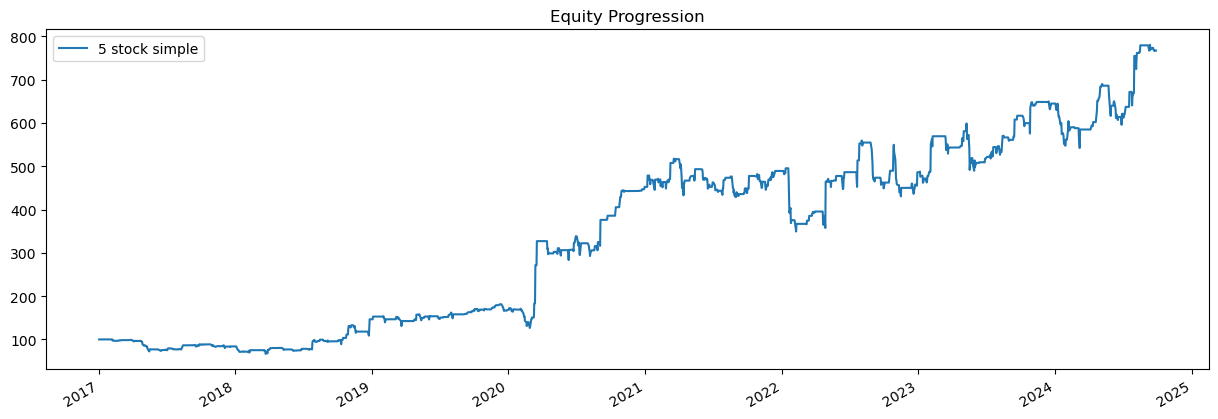

In [24]:
# Set the Moveing Averge window
window = 24

# Calculate the SMA with this Widnow
sma = backtest_data.rolling(window).mean()

# Calculate the Upper and Lower Bollinger bands
upper_boll_1 = sma + 2*backtest_data.rolling(window=window).std()
lower_boll_1 = sma - 2*backtest_data.rolling(window=window).std()
upper_boll_2 = sma + 1*backtest_data.rolling(window=window).std()
lower_boll_2 = sma - 1*backtest_data.rolling(window=window).std()


# Copy the structure of the stock data, mainly the date column
signal = backtest_data.copy()

# Set values in df to NaN
signal[:] = np.nan

# Buy signal when the price drops below the 2std lower bollinger line 
buy_condition = ((backtest_data < lower_boll_1))
signal[buy_condition] = True  # Buy signal (True)



# Sell signal when the price is above the 2std upper Bollinger line
sell_condition = ((backtest_data > upper_boll_1))
signal[sell_condition] = False

# Create the Weight allocation class 
class WeighTarget(bt.Algo):
    
    def __init__(self, target_weights, signal):
        self.tw = target_weights
        self.signal = signal
    
    def __call__(self, target):
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            w = w.where(self.signal.loc[target.now].notna(), other=0)
            
            target.temp['weights'] = w.dropna()
    
        return True


# Produce the target weight df 
tw = backtest_data.copy()

# Set inital weights to 0
tw[:] = 0.0

# Outline the conditions of the outside bands by negating the condition that is inside
outside_bands = ~((backtest_data < upper_boll_2) & (backtest_data > lower_boll_2))

# Set-up a df that will keep track if we are entered into a position or not
in_pos = tw.copy()
in_pos[:] = np.nan

# Sets to True when the buy(long) or sell(short) condition is true
in_pos[buy_condition | sell_condition] = True

# We forward fill the df to 'hold' the position 
in_pos.ffill(inplace = True)

# We exit out of positionby setting to false when not outside (inside) the stable zone
in_pos[~((outside_bands))] = False

# Set weight to 1.0 (long position) when the price is below the Lower bollinger line
tw[((backtest_data < lower_boll_1))] = 1.0

# Set weight to -1.0 (short) when price is above the Upper bollinger line
tw[((backtest_data > upper_boll_1))] = -1.0

# Now we need to iterate through rows to propagate holding positions
for i in range(1, len(tw)):
    # Loops through each ticker ('AAPL', 'META')
    for col in tw.columns:
        # Use .loc to access rows/columns using label-based indexing
        if tw.loc[tw.index[i-1], col] == 1.0 and outside_bands.loc[tw.index[i], col] and in_pos.loc[tw.index[i], col]:
            # If the previous row had a long position and the price is still outside bands and we're in position
            tw.loc[tw.index[i], col] = 1.0  # Hold long position
        elif tw.loc[tw.index[i-1], col] == -1.0 and outside_bands.loc[tw.index[i], col] and in_pos.loc[tw.index[i], col]:
            # If the previous row had a short position and the price is still outside bands and we're in position
            tw.loc[tw.index[i], col] = -1.0  # Hold short position


# Produce the Strategy
s = bt.Strategy('5 stock simple', [bt.algos.RunDaily(),             # Run Daily
                          bt.algos.SelectAll(),            # Select all stocks
                          WeighTarget(tw,signal),          # Weight allocation
                          bt.algos.Rebalance()])           # Rebalance


# now we create the Backtest
t = bt.Backtest(s, backtest_data, initial_capital = 1000)

# Run the Backtest
res = bt.run(t)

# Plot the Backtest
res.plot()
res.display()
stats = res.stats 
m = pd.concat([m, stats], axis=1)


We saw a total return of 667%, a yearly Sharpe of 0.76, avg drawdown of -10.18% and the worst year was -0.62%. This is a good return but is slightly risky.

## 5 Stock Mean Reversion + RSI

Calculate the RSI using the same code as before and add to the strategy

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


Stat                 5 stock RSI
-------------------  -------------
Start                2017-01-02
End                  2024-09-27
Risk-free rate       0.00%

Total Return         483.27%
Daily Sharpe         1.02
Daily Sortino        2.37
CAGR                 25.61%
Max Drawdown         -26.88%
Calmar Ratio         0.95

MTD                  1.94%
3m                   23.27%
6m                   17.36%
YTD                  18.62%
1Y                   20.91%
3Y (ann.)            18.26%
5Y (ann.)            27.91%
10Y (ann.)           -
Since Incep. (ann.)  25.61%

Daily Sharpe         1.02
Daily Sortino        2.37
Daily Mean (ann.)    25.79%
Daily Vol (ann.)     25.18%
Daily Skew           7.47
Daily Kurt           105.51
Best Day             27.32%
Worst Day            -9.09%

Monthly Sharpe       1.01
Monthly Sortino      2.74
Monthly Mean (ann.)  26.25%
Monthly Vol (ann.)   25.90%
Monthly Skew         1.80
Monthly Kurt         6.36
Best Month           37.83%
Worst Month          

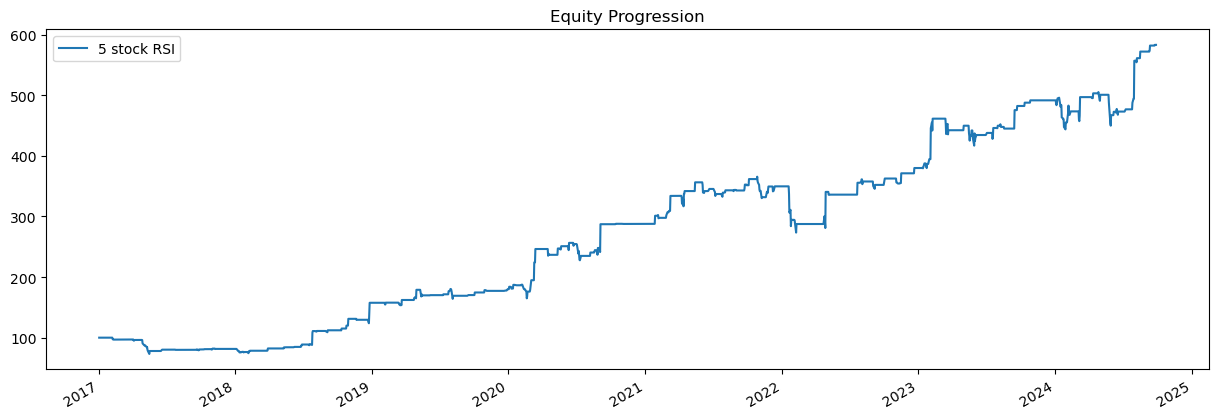

In [25]:
# To calculate the RSI we need t calculate the difference in prices between successive intervals
change = backtest_data.diff()
change.dropna(inplace=True)
change_up = change.copy()
change_down = change.copy()

# Keep only the positive differences in the change up list
change_up[change_up<0] = 0

# Keep only the negative difference in the change down list
change_down[change_down>0] = 0

# Take the average upwawrds movement and average downwards movement over a a 14 day window
avg_up = change_up.rolling(14).mean()
avg_down = change_down.rolling(14).mean().abs()

# RSI is calculated by the propertion of upards movements from total movement(up + down). We take as value between 0 and 100
RSI = 100 * avg_up / (avg_up + avg_down)

# Set the Moveing Averge window
window = 24

# Calculate the SMA with this Widnow
sma = backtest_data.rolling(window).mean()

# Calculate the Upper and Lower Bollinger bands
upper_boll_1 = sma + 2*backtest_data.rolling(window=window).std()
lower_boll_1 = sma - 2*backtest_data.rolling(window=window).std()
upper_boll_2 = sma + 1*backtest_data.rolling(window=window).std()
lower_boll_2 = sma - 1*backtest_data.rolling(window=window).std()


# Copy the structure of the stock data, mainly the date column
signal = backtest_data.copy()

# Set values in df to NaN
signal[:] = np.nan

# Buy signal when the price drops below the 2std lower bollinger line and the RSI < 25 (oversold)
buy_condition = ((backtest_data < lower_boll_1) & (RSI < 25))
signal[buy_condition] = True  # Buy signal (True)



# Sell signal when the price is above the 2std upper Bollinger line and the RSI > 75 (verbought)
sell_condition = ((backtest_data > upper_boll_1) & (RSI > 75))
signal[sell_condition] = False

# Create the Weight allocation class 
class WeighTarget(bt.Algo):
    
    def __init__(self, target_weights, signal):
        self.tw = target_weights
        self.signal = signal
    
    def __call__(self, target):
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            w = w.where(self.signal.loc[target.now].notna(), other=0)
            
            target.temp['weights'] = w.dropna()
    
        return True


# Produce the target weight df 
tw1 = backtest_data.copy()

# Set inital weights to 0
tw[:] = 0.0

# Outline the conditions of the outside bands by negating the condition that is inside
outside_bands = ~((backtest_data < upper_boll_2) & (backtest_data > lower_boll_2))

# Set-up a df that will keep track if we are entered into a position or not
in_pos = tw.copy()
in_pos[:] = np.nan

# Sets to True when the buy(long) or sell(short) condition is true
in_pos[buy_condition | sell_condition] = True

# We forward fill the df to 'hold' the position 
in_pos.ffill(inplace = True)

# We exit out of positionby setting to false when not outside (inside) the stable zone
in_pos[(~((outside_bands))) ] = False

# Set weight to 1.0 (long position) when the price is below the Lower bollinger line
tw[((backtest_data < lower_boll_1))] = 1.0

# Set weight to -1.0 (short) when price is above the Upper bollinger line
tw[((backtest_data > upper_boll_1))] = -1.0

# Now we need to iterate through rows to propagate holding positions
for i in range(1, len(tw)):
    # Loops through each ticker ('AAPL', 'META')
    for col in tw.columns:
        # Use .loc to access rows/columns using label-based indexing
        if tw.loc[tw.index[i-1], col] == 1.0 and outside_bands.loc[tw.index[i], col] and in_pos.loc[tw.index[i], col]:
            # If the previous row had a long position and the price is still outside bands and we're in position
            tw.loc[tw.index[i], col] = 1.0  # Hold long position
        elif tw.loc[tw.index[i-1], col] == -1.0 and outside_bands.loc[tw.index[i], col] and in_pos.loc[tw.index[i], col]:
            # If the previous row had a short position and the price is still outside bands and we're in position
            tw.loc[tw.index[i], col] = -1.0  # Hold short position
        

# Produce the Strategy
s = bt.Strategy('5 stock RSI', [bt.algos.RunDaily(),             # Run Daily
                          bt.algos.SelectAll(),            # Select all stocks
                          WeighTarget(tw,signal),          # Weight allocation
                          bt.algos.Rebalance()])           # Rebalance


# now we create the Backtest
t = bt.Backtest(s, backtest_data, initial_capital = 1000)

# Run the Backtest
res = bt.run(t)

# Plot the Backtest
res.plot()

res.display()
stats = res.stats 
m = pd.concat([m, stats], axis=1)


We saw a total return of 483%, a yearly Sharpe of 1.14, avg drawdown of -5.38% and our worst year was +8.65%. 
We again see that including the RSI provides a more stable strategy and provides less risk. However, this is at the expense of total returns. 

## 5 Stock Mean Reversion + ADX momentum 

Lets now try the ADX indicator.

In [26]:
# Import an ADX function from ta
from ta.trend import ADXIndicator 

In [27]:
# Function to calculate ADX for a stock's data using ADXIndicator from ta
def calculate_adx_with_ta(stock_data, period=14):
    # Calculte th adx for the given stock
    adx_ind = ADXIndicator(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Close'], window=period)
    
    # Get the adx series form the instance
    adx = adx_ind.adx()
    
    return adx



Calcuate the ADX for each stock and save in a df. Thus needs to have the correct date index.

In [28]:
# Define the stock symbols that correspond to the data in the same order
stock_symbols = ['AAPL', 'META', 'AMZN', 'NVDA', 'GOOG']

n = backtest_data.copy()
n[:] = np.nan

# Assuming data[0] is a list, and each element is stock data for the respective symbol in stock_symbols
for i, stock_data in enumerate(data[0]):
    # Calculate ADX using the `calculate_adx_with_ta` function
    dfdf = calculate_adx_with_ta(stock_data, period=14)


    # Assuming dfdf contains an ADX series with a DateTime index, assign it to the correct column
    n[stock_symbols[i]] = dfdf.values  # Use .values to ensure correct shape

# Now, m should have the same index structure as backtest_data
# Display the resulting DataFrame
ADX = pd.DataFrame(n, index=backtest_data.index)
ADX

,AAPL,META,AMZN,NVDA,GOOG
Date,,,,,
2017-01-03,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-04,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-05,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-06,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-09,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2024-09-23,15.067182,18.688719,18.417009,16.147977,27.488069
2024-09-24,14.887306,19.728207,19.134050,15.267233,25.701863
2024-09-25,14.332929,21.140585,19.799874,15.029933,24.043242


Now add this to the strategy. As ADX only measures strength and not direction, we qualify both long and short with an ADX over 25.

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


Stat                 5 stock ADX
-------------------  -------------
Start                2017-01-02
End                  2024-09-27
Risk-free rate       0.00%

Total Return         1374.81%
Daily Sharpe         1.20
Daily Sortino        3.50
CAGR                 41.61%
Max Drawdown         -19.95%
Calmar Ratio         2.09

MTD                  0.14%
3m                   16.52%
6m                   35.29%
YTD                  31.83%
1Y                   32.09%
3Y (ann.)            24.52%
5Y (ann.)            46.18%
10Y (ann.)           -
Since Incep. (ann.)  41.61%

Daily Sharpe         1.20
Daily Sortino        3.50
Daily Mean (ann.)    39.70%
Daily Vol (ann.)     33.19%
Daily Skew           11.00
Daily Kurt           202.96
Best Day             49.32%
Worst Day            -11.99%

Monthly Sharpe       0.76
Monthly Sortino      6.40
Monthly Mean (ann.)  46.06%
Monthly Vol (ann.)   60.71%
Monthly Skew         7.44
Monthly Kurt         63.58
Best Month           155.85%
Worst Month     

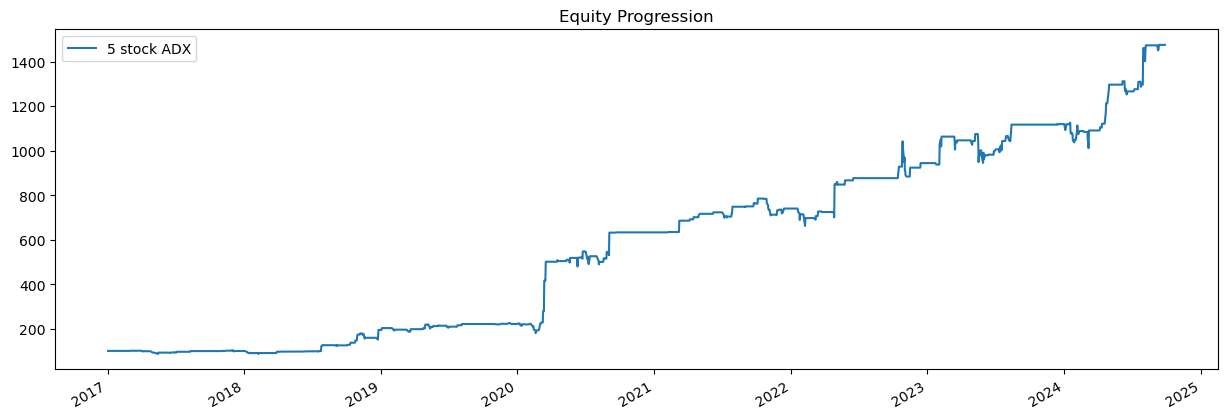

In [29]:

# Copy the structure of the stock data, mainly the date column
signal = backtest_data.copy()

# Set values in df to NaN
signal[:] = np.nan

# Buy signal when the price drops below the 2std lower bollinger line and the RSI < 25 (oversold)
buy_condition = ((backtest_data < lower_boll_1) & (ADX > 25))
signal[buy_condition] = True  # Buy signal (True)



# Sell signal when the price is above the 2std upper Bollinger line and the RSI > 75 (verbought)
sell_condition = ((backtest_data > upper_boll_1) & (ADX > 25))
signal[sell_condition] = False

# Create the Weight allocation class 
class WeighTarget(bt.Algo):
    
    def __init__(self, target_weights, signal):
        self.tw = target_weights
        self.signal = signal
    
    def __call__(self, target):
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            w = w.where(self.signal.loc[target.now].notna(), other=0)
            
            target.temp['weights'] = w.dropna()
    
        return True


# Produce the target weight df 
tw = backtest_data.copy()

# Set inital weights to 0
tw[:] = 0.0

# Outline the conditions of the outside bands by negating the condition that is inside
outside_bands = ~((backtest_data < upper_boll_2) & (backtest_data > lower_boll_2))

# Set-up a df that will keep track if we are entered into a position or not
in_pos = tw.copy()
in_pos[:] = np.nan

# Sets to True when the buy(long) or sell(short) condition is true
in_pos[buy_condition | sell_condition] = True

# We forward fill the df to 'hold' the position 
in_pos.ffill(inplace = True)

# We exit out of positionby setting to false when not outside (inside) the stable zone
in_pos[(~((outside_bands))) ] = False

# Set weight to 1.0 (long position) when the price is below the Lower bollinger line
tw[((backtest_data < lower_boll_1))] = 1.0

# Set weight to -1.0 (short) when price is above the Upper bollinger line
tw[((backtest_data > upper_boll_1))] = -1.0

# Now we need to iterate through rows to propagate holding positions
for i in range(1, len(tw)):
    # Loops through each ticker ('AAPL', 'META')
    for col in tw.columns:
        # Use .loc to access rows/columns using label-based indexing
        if tw.loc[tw.index[i-1], col] == 1.0 and outside_bands.loc[tw.index[i], col] and in_pos.loc[tw.index[i], col]:
            # If the previous row had a long position and the price is still outside bands and we're in position
            tw.loc[tw.index[i], col] = 1.0  # Hold long position
        elif tw.loc[tw.index[i-1], col] == -1.0 and outside_bands.loc[tw.index[i], col] and in_pos.loc[tw.index[i], col]:
            # If the previous row had a short position and the price is still outside bands and we're in position
            tw.loc[tw.index[i], col] = -1.0  # Hold short position
        

# Produce the Strategy
s = bt.Strategy('5 stock ADX', [bt.algos.RunDaily(),             # Run Daily
                          bt.algos.SelectAll(),            # Select all stocks
                          WeighTarget(tw,signal),          # Weight allocation
                          bt.algos.Rebalance()])           # Rebalance


# now we create the Backtest
t = bt.Backtest(s, backtest_data, initial_capital = 1000)

# Run the Backtest
res = bt.run(t)

# Plot the Backtest
res.plot()

res.display()
stats = res.stats 
m = pd.concat([m, stats], axis=1)


We saw a total return of 1374%, a year;y sharpe of 0.87, avg drawdown of -6.20% and our worst year was 13.77%. Below are the results of all tests so we can assess teh imporvement.

In [30]:
display(m)

,2 stock simple,2 stock RSI,5 stock simple,5 stock RSI,5 stock ADX
start,2017-01-02 00:00:00,2017-01-02 00:00:00,2017-01-02 00:00:00,2017-01-02 00:00:00,2017-01-02 00:00:00
end,2024-09-27 00:00:00,2024-09-27 00:00:00,2024-09-27 00:00:00,2024-09-27 00:00:00,2024-09-27 00:00:00
rf,0.0,0.0,0.0,0.0,0.0
total_return,2.169604,1.582945,6.67184,4.832702,13.748099
cagr,0.16085,0.130533,0.301399,0.25609,0.416147
max_drawdown,-0.204129,-0.09691,-0.335641,-0.268755,-0.199487
calmar,0.787981,1.346952,0.89798,0.952877,2.086082
mtd,-0.005897,0.002095,-0.015397,0.01941,0.001434
three_month,0.096593,0.049953,0.287761,0.232736,0.165184
six_month,0.052449,0.046238,0.311868,0.173568,0.352867


We can see from these metrics that the inclusion of momentum indicators imporves the mean reversion strategy. Whilst the RSI has reduced returns over the simple models, it is less volatile with lower drawdowns and bettwer risk adjusted returns. When we inlcude the ADX we see superior returns and risk-adjusted metrics suggesting that the combination of the mean reversion with ADX is the best strategy.